In [12]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
using Test

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1342


In [13]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
        legendfont = font("CMU Serif", 18),
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

In [27]:
Δtgif = 0.5

# Pressure sensors
Δs = 0.5
sensors = complex.(collect(-1.5:Δs:10.0))
Ny = length(sensors)


rpatch = 0.5 # initial radius of the vortex patch
dpatch = 1.2 # initial distance between patch centroids
Γpatch = 6.0 # strength of patch.
Upatch = Γpatch/(2*π*dpatch)
Nring = 4  # number of rings in each patch.
# The uncertainty is set to a small fraction 10% of the Δr between two consecutive rings
σr =  0.1*rpatch/(Nring-1/2)
σΓ =  1e-2
# Δt = 0.01#0.005*π^2*d0^2/abs(Γ0) # set the time step


config_data = let Nv = 1+(8*(Nring-1)*Nring)÷2, 
             U = complex(0.0),
             ss = sensors, Δt = 5e-3, δ = 5e-2,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 2e-1
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Nv = config_data.Nv

xgrid = range(-2, 10, length= 800)
ygrid = range(-2, 2, length=100)

t0 = 0.0
tf = 12.0
tspan = (t0, tf)

config = deepcopy(config_data);

Nx = 3*config.Nv
Ny = length(config.ss)

24

In [28]:
Ne = 1000

1000

In [29]:
function spectrumCxCy(X, tsnap)
#     Ne = size(X[1],2)
    Cx = zeros(Nx, Nx)
    Cy = zeros(Ny, Ny)
    
    freestream = Freestream(complex(0.0))

    Xcxcy = deepcopy(vcat(zeros(Ny, Ne), X))

    ϵX = config.ϵX
    ϵΓ = config.ϵΓ
    β = config.β
    ϵY = config.ϵY

    ϵx = RecipeInflation([ϵX; ϵΓ])
    ϵmul = MultiplicativeInflation(β)

    # Perform state inflation
    ϵmul(Xcxcy, Ny+1, Ny+Nx)
    ϵx(Xcxcy, Ny, Nx, config)
    Dx = Diagonal(std(Xcxcy[Ny+1:end,:]; dims = 2)[:,1])
    # Dx = I
    Dϵ = config.ϵY*I
    
    @inbounds for i=1:Ne
        J = symmetric_analytical_jacobian_pressure(config.ss, vcat(state_to_lagrange(Xcxcy[Ny+1:end,i], config)...), 
                                                   tsnap)
        Ji = J[:,1:3*config.Nv]
        Cx .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)'*(inv(Dϵ)*Ji*Dx)
        Cy .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)*(inv(Dϵ)*Ji*Dx)'
    end
    
    Px, σx = svd(cov(Xcxcy[Ny+1:Ny+Nx,:]'))
    
    Vx, Λx = svd(Symmetric(Cx))
    Vy, Λy = svd(Symmetric(Cy))
    
    

    Λx = sort(abs.(Λx); rev = true)
    Λy = sort(abs.(Λy); rev = true)

    
    return Px, σx, Λx, Vx, Λy, Vy
end

spectrumCxCy (generic function with 2 methods)

In [30]:
Nx = 3*config.Nv

147

In [31]:
#  Xfenkf = load("/media/mat/HDD/Paper Potential Flow/Example 3/ensemble_EnKF_Ne_"*string(Ne)*".jld")["Xf"];

In [32]:
# save("/media/mat/HDD/Paper Potential Flow/Example 3/ensemble_reduced_Xf_EnKF_Ne_"*string(Ne)*".jld", "Xf", Xfenkf[1:10:end])
Xfenkf = load("/media/mat/HDD/Paper Potential Flow/Example 3/ensemble_reduced_Xf_EnKF_Ne_"*string(Ne)*".jld")["Xf"]

241-element Vector{Matrix{Float64}}:
 [-0.0007759839326874734 -0.012989602091847456 … 0.010683696446410634 1.4136178830598978e-5; 0.5949664892967805 0.5791130269313286 … 0.5941758472693005 0.6001628669843401; … ; 0.514239563819475 0.5003074163113741 … 0.4980260896380123 0.49562438824104826; 0.11653657602377104 0.11286178959984863 … 0.13689645116044272 0.1341022480458321]
 [0.03850395994875214 0.028217948035796754 … 0.048223965566961575 0.03720346463200132; 0.5945628638202655 0.5819708927337891 … 0.5940118573827493 0.5999983054042061; … ; 0.5813572704387685 0.5619027099315402 … 0.5623342254417891 0.5589180090683458; 0.11637332509000478 0.11332636257180782 … 0.13800979550802403 0.1338839663799156]
 [0.0777595284645666 0.06819812990973056 … 0.08661604475584199 0.07429388831881797; 0.5930034746531477 0.585440448016698 … 0.5935509360325425 0.5996596094964144; … ; 0.6520537998187059 0.627328535150391 … 0.6300586929626534 0.6258957002716302; 0.11678428401615569 0.11353445211748867 … 0.1376963

In [33]:
Λxtab = Vector{Float64}[]
Λytab = Vector{Float64}[]

tlist = collect(0.0:0.1:12.0)

@showprogress for tsnap in tlist   
    nsnap = ceil(Int64, tsnap/0.5)+1
    Px, σx, Λx, Vx, Λy, Vy = spectrumCxCy(Xfenkf[nsnap], tsnap)
    
    push!(Λxtab, deepcopy(Λx))
    push!(Λytab, deepcopy(Λy))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:07


In [34]:
# map(y->cumsum(y)./sum(y), eachcol(hcat(Λxtab...)'))[1]

In [35]:
q5_Λx = map(x-> quantile(x, 0.05), eachcol(hcat(Λxtab...)'))
q25_Λx = map(x-> quantile(x, 0.25), eachcol(hcat(Λxtab...)'))
q50_Λx = map(x-> quantile(x, 0.50), eachcol(hcat(Λxtab...)'))
q75_Λx = map(x-> quantile(x, 0.75), eachcol(hcat(Λxtab...)'))
q95_Λx = map(x-> quantile(x, 0.95), eachcol(hcat(Λxtab...)'))


q5_Ex  = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q25_Ex = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q50_Ex = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q75_Ex = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q95_Ex = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))


q5_deltaΛx = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q25_deltaΛx = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q50_deltaΛx = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q75_deltaΛx = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q95_deltaΛx = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))

q5_Λy = map(x-> quantile(x, 0.05), eachcol(hcat(Λytab...)'))
q25_Λy = map(x-> quantile(x, 0.25), eachcol(hcat(Λytab...)'))
q50_Λy = map(x-> quantile(x, 0.50), eachcol(hcat(Λytab...)'))
q75_Λy = map(x-> quantile(x, 0.75), eachcol(hcat(Λytab...)'))
q95_Λy = map(x-> quantile(x, 0.95), eachcol(hcat(Λytab...)'))


q5_Ey  = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q25_Ey = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q50_Ey = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q75_Ey = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q95_Ey = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))


q5_deltaΛy = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q25_deltaΛy = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q50_deltaΛy = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q75_deltaΛy = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q95_deltaΛy = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'));

In [36]:
Xxlist = Float64[]
Xxliststring = String[]
for i=10:Nx
    if mod(i, 10) == 0 || i ∈ [10; 50; Nx]
        push!(Xxlist, i)
    end
#         push!(Xxliststring, "")
#     end
    if i ∈ [10; 50; Nx]
        push!(Xxliststring, latexstring("$i"))   
    elseif !(i ∈ [10; 50; Nx]) && mod(i, 10) == 0
       push!(Xxliststring, "")
    end
end


@show size(Xxlist)
@show size(Xxliststring)

size(Xxlist) = (15,)
size(Xxliststring) = (15,)


(15,)

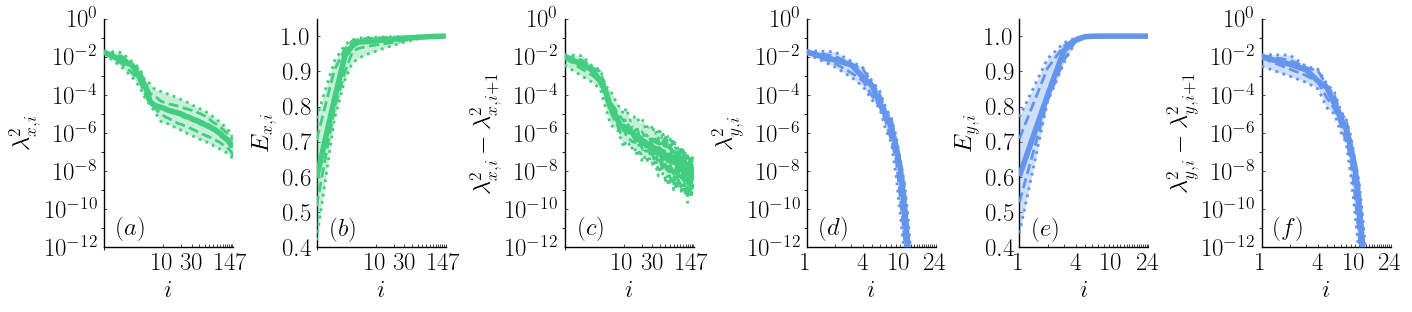

In [38]:
c_cx = colorant"tomato"
c_cx = colorant"seagreen3"
c_cy = colorant"cornflowerblue"

ylist = Float64[]
yliststring = String[]
for i=0:-2:-12
    push!(ylist, (10.0)^i)
    if mod(i, 2) == 0
        push!(yliststring, latexstring("10^{$i}"))
    else
        push!(yliststring, "")
    end
end



Xxlist = Float64[]
Xxliststring = String[]
for i=1:Nx
    if mod(i, 10) == 0 || i ∈ [10; 30; Nx]
        push!(Xxlist, i)
    end
#         push!(Xxliststring, "")
#     end
    if i ∈ [10; 30; Nx]
        push!(Xxliststring, latexstring("$i"))   
    elseif !(i ∈ [10; 30; Nx]) && mod(i, 10) == 0
       push!(Xxliststring, "")
    end
end


Yxlist = Float64[]
Yxliststring = String[]
for i=1:24
    push!(Yxlist, i)
    if i ∈ [1; 4; 10; 24]
        push!(Yxliststring, latexstring("$i"))
    else
        push!(Yxliststring, "")
    end
end


plt = plot(layout = grid(1,6), xlims = (1, 150), legend = false, size = (1400, 300))


# Cx eigenvalues
plot!(plt[1,1], ylims = (10.0^(-12), 10.0^(-1)), yscale = :log10, xscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda^2_{x, i}", xticks = (Xxlist, Xxliststring))


plot!(plt[1,1], 1:Nx, q5_Λx, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,1], 1:Nx, q25_Λx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,1], 1:Nx, q50_Λx, linewidth = 4, color = c_cx)
plot!(plt[1,1], 1:Nx, q75_Λx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,1], 1:Nx, q95_Λx, linewidth = 2, linestyle = :dot, color = c_cx)


plot!(plt[1,1], 1:Nx, [q50_Λx q50_Λx], linewidth = 0.0,
      fillrange = [q5_Λx q95_Λx], alpha = 0.3, color = c_cx,
      label = "") 

annotate!(plt[1,1], 3, 10.0^(-11), L"(a)")

# Cx cumulative energy
plot!(plt[1,2], xlabel = L"i", ylabel = L"E_{x, i}", ylim = (0.4, 1.05), xlims = (1, Inf),
     xticks = (Xxlist, Xxliststring), xscale = :log10)


plot!(plt[1,2], 1:Nx, q5_Ex, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,2], 1:Nx, q25_Ex, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,2], 1:Nx, q50_Ex, linewidth = 4, color = c_cx)
plot!(plt[1,2], 1:Nx, q75_Ex, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,2], 1:Nx, q95_Ex, linewidth = 2, linestyle = :dot, color = c_cx)

plot!(plt[1,2], 1:Nx, [q50_Ex q50_Ex], linewidth = 0.0,
      fillrange = [q5_Ex q95_Ex], alpha = 0.3, color = c_cx,
      label = "") 

annotate!(plt[1,2], 3, 0.45, L"(b)")


# Cx Spectral gap 
plot!(plt[1,3], ylims = (10.0^(-12), 10.0^(-1)), xscale = :log10, yscale = :log10, 
      yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda^2_{x, i} - \lambda^2_{x, i+1}", xticks = (Xxlist, Xxliststring))



plot!(plt[1,3], 1:Nx-1, q5_deltaΛx, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q25_deltaΛx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q50_deltaΛx, linewidth = 4, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q75_deltaΛx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q95_deltaΛx, linewidth = 2, linestyle = :dot, color = c_cx)

plot!(plt[1,3], 1:Nx-1, [q50_deltaΛx q50_deltaΛx], linewidth = 0.0,
      fillrange = [q5_deltaΛx q95_deltaΛx], alpha = 0.3, color = c_cx,
      label = "")

annotate!(plt[1,3], 3, 10.0^(-11), L"(c)")

# Cy eigenvalues
plot!(plt[1,4], xlims = (1, Inf), ylims = (10.0^(-12), 10.0^(-1)), xscale = :log10, yscale = :log10, yticks = (ylist, yliststring),
              xlabel = L"i", ylabel = L"\lambda^2_{y, i}", xticks = (Yxlist, Yxliststring))


plot!(plt[1,4], 1:Ny, q5_Λy, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,4], 1:Ny, q25_Λy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,4], 1:Ny, q50_Λy, linewidth = 4, color = c_cy)
plot!(plt[1,4], 1:Ny, q75_Λy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,4], 1:Ny, q95_Λy, linewidth = 2, linestyle = :dot, color = c_cy)


plot!(plt[1,4], 1:Ny, [q50_Λy q50_Λy], linewidth = 0.0,
      fillrange = [q5_Λy q95_Λy], alpha = 0.3, color = c_cy,
      label = "") 


annotate!(plt[1,4], 2, 10.0^(-11), L"(d)")

# Cy cumulative energy
plot!(plt[1,5], xlabel = L"i", ylabel = L"E_{y, i}", xscale = :log10,
      ylim = (0.4, 1.05), xlims = (1, Inf), 
      xticks = (Yxlist, Yxliststring))


plot!(plt[1,5], 1:Ny, q5_Ey, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,5], 1:Ny, q25_Ey, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,5], 1:Ny, q50_Ey, linewidth = 4, color = c_cy)
plot!(plt[1,5], 1:Ny, q75_Ey, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,5], 1:Ny, q95_Ey, linewidth = 2, linestyle = :dot, color = c_cy)

plot!(plt[1,5], 1:Ny, [q50_Ey q50_Ey], linewidth = 0.0,
      fillrange = [q5_Ey q95_Ey], alpha = 0.3, color = c_cy,
      label = "") 

annotate!(plt[1,5], 2, 0.45, L"(e)")

# Cy Spectral gap 
plot!(plt[1,6], xlims = (1, Inf), ylims = (10.0^(-12), 10.0^(-1)), xscale = :log10, yscale = :log10, 
      yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda^2_{y, i} - \lambda^2_{y, i+1}", xticks = (Yxlist, Yxliststring))



plot!(plt[1,6], q5_deltaΛy, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,6], q25_deltaΛy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,6], q50_deltaΛy, linewidth = 4, color = c_cy)
plot!(plt[1,6], q75_deltaΛy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,6], q95_deltaΛy, linewidth = 2, linestyle = :dot, color = c_cy)

plot!(plt[1,6], [q50_deltaΛy q50_deltaΛy], linewidth = 0.0,
      fillrange = [q5_deltaΛy q95_deltaΛy], alpha = 0.3, color = c_cy,
      label = "")

annotate!(plt[1,6], 2, 10.0^(-11), L"(f)")


savefig("vortexpatch_energy_spectrum_log.pdf")

In [84]:
q5_Ex[10]

0.957305193858343

In [16]:
q50_Ex[2]

0.820796565219165

In [17]:
q50_Ey[5]

0.9981280668878697

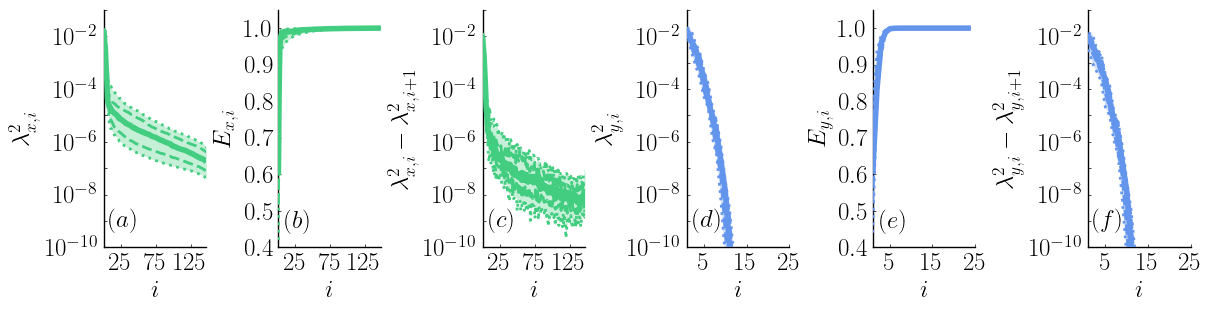

In [39]:
c_cx = colorant"tomato"
c_cx = colorant"seagreen3"
c_cy = colorant"cornflowerblue"

ylist = Float64[]
yliststring = String[]
for i=-1:-1:-10
    push!(ylist, (10.0)^i)
    if mod(i, 2) == 0
        push!(yliststring, latexstring("10^{$i}"))
    else
        push!(yliststring, "")
    end
end


Xxlist = [25; 75; 125]#; 150]
Xxliststring = string.(Xxlist)

Yxlist = [5; 15; 25]
Yxliststring = string.(Yxlist)


plt = plot(layout = grid(1,6), xlims = (1, Inf), legend = false, size = (1200, 300))


# Cx eigenvalues
plot!(plt[1,1], ylims = (10.0^(-10), 10.0^(-1)), yscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda^2_{x, i}", xticks = (Xxlist, Xxliststring))


plot!(plt[1,1], 1:Nx, q5_Λx, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,1], 1:Nx, q25_Λx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,1], 1:Nx, q50_Λx, linewidth = 4, color = c_cx)
plot!(plt[1,1], 1:Nx, q75_Λx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,1], 1:Nx, q95_Λx, linewidth = 2, linestyle = :dot, color = c_cx)


plot!(plt[1,1], 1:Nx, [q50_Λx q50_Λx], linewidth = 0.0,
      fillrange = [q5_Λx q95_Λx], alpha = 0.3, color = c_cx,
      label = "") 

annotate!(plt[1,1], 30, 10.0^(-9), L"(a)")

# Cx cumulative energy
plot!(plt[1,2], xlabel = L"i", ylabel = L"E_{x, i}", ylim = (0.4, 1.05), xlims = (1, Inf),
      xticks = (Xxlist, Xxliststring))


plot!(plt[1,2], 1:Nx, q5_Ex, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,2], 1:Nx, q25_Ex, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,2], 1:Nx, q50_Ex, linewidth = 4, color = c_cx)
plot!(plt[1,2], 1:Nx, q75_Ex, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,2], 1:Nx, q95_Ex, linewidth = 2, linestyle = :dot, color = c_cx)

plot!(plt[1,2], 1:Nx, [q50_Ex q50_Ex], linewidth = 0.0,
      fillrange = [q5_Ex q95_Ex], alpha = 0.3, color = c_cx,
      label = "") 

annotate!(plt[1,2], 30, 0.47, L"(b)")


# Cx Spectral gap 
plot!(plt[1,3], ylims = (10.0^(-10), 10.0^(-1)), yscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda^2_{x, i} - \lambda^2_{x, i+1}", xticks = (Xxlist, Xxliststring))



plot!(plt[1,3], 1:Nx-1, q5_deltaΛx, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q25_deltaΛx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q50_deltaΛx, linewidth = 4, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q75_deltaΛx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q95_deltaΛx, linewidth = 2, linestyle = :dot, color = c_cx)

plot!(plt[1,3], 1:Nx-1, [q50_deltaΛx q50_deltaΛx], linewidth = 0.0,
      fillrange = [q5_deltaΛx q95_deltaΛx], alpha = 0.3, color = c_cx,
      label = "")

annotate!(plt[1,3], 30, 10.0^(-9), L"(c)")

# Cy eigenvalues
plot!(plt[1,4], ylims = (10.0^(-9), 10.0^(-1)), yscale = :log10, yticks = (ylist, yliststring),
              xlabel = L"i", ylabel = L"\lambda^2_{y, i}", xticks = (Yxlist, Yxliststring))


plot!(plt[1,4], 1:Ny, q5_Λy, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,4], 1:Ny, q25_Λy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,4], 1:Ny, q50_Λy, linewidth = 4, color = c_cy)
plot!(plt[1,4], 1:Ny, q75_Λy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,4], 1:Ny, q95_Λy, linewidth = 2, linestyle = :dot, color = c_cy)


plot!(plt[1,4], 1:Ny, [q50_Λy q50_Λy], linewidth = 0.0,
      fillrange = [q5_Λy q95_Λy], alpha = 0.3, color = c_cy,
      label = "") 


annotate!(plt[1,4], 6, 10.0^(-9), L"(d)")

# Cy cumulative energy
plot!(plt[1,5], xlabel = L"i", ylabel = L"E_{y, i}", ylim = (0.4, 1.05), xlims = (1, Inf), 
      xticks = (Yxlist, Yxliststring))


plot!(plt[1,5], 1:Ny, q5_Ey, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,5], 1:Ny, q25_Ey, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,5], 1:Ny, q50_Ey, linewidth = 4, color = c_cy)
plot!(plt[1,5], 1:Ny, q75_Ey, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,5], 1:Ny, q95_Ey, linewidth = 2, linestyle = :dot, color = c_cy)

plot!(plt[1,5], 1:Ny, [q50_Ey q50_Ey], linewidth = 0.0,
      fillrange = [q5_Ey q95_Ey], alpha = 0.3, color = c_cy,
      label = "") 

annotate!(plt[1,5], 6, 0.47, L"(e)")

# Cy Spectral gap 
plot!(plt[1,6], ylims = (10.0^(-10), 10.0^(-1)), yscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda^2_{y, i} - \lambda^2_{y, i+1}", xticks = (Yxlist, Yxliststring))



plot!(plt[1,6], q5_deltaΛy, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,6], q25_deltaΛy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,6], q50_deltaΛy, linewidth = 4, color = c_cy)
plot!(plt[1,6], q75_deltaΛy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,6], q95_deltaΛy, linewidth = 2, linestyle = :dot, color = c_cy)

plot!(plt[1,6], [q50_deltaΛy q50_deltaΛy], linewidth = 0.0,
      fillrange = [q5_deltaΛy q95_deltaΛy], alpha = 0.3, color = c_cy,
      label = "")

annotate!(plt[1,6], 6, 10.0^(-9), L"(f)")


savefig("vortexpatch_energy_spectrum.pdf")